### Imports

In order to use a package I have created, as well as other packages, we have to import them. If you haven't used a jupyter notebook before then you can press control enter to run the code blocks.

In [1]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # SMC / Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

# The sim package is my package (in the sim folder)
from sim.model import WildcatModel
from sim.utils import ScaledDist
from sim.sum_stats import simple_sum

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

### Run a simulation

In [2]:
%%time

model = WildcatModel(seq_length=int(10e6), recombination_rate=1.8e-8, mutation_rate=6e-8)

data = model.simulate(
        bottleneck_strength_domestic=3000,
        bottleneck_strength_wild=30000,
        bottleneck_time_domestic=3000,
        bottleneck_time_wild=4000,
        captive_time=20,
        div_time=40000,
        mig_length_post_split=1000,
        mig_length_wild=20,
        mig_rate_captive=0.01,
        mig_rate_post_split=0.1,
        mig_rate_wild=0.01,
        pop_size_captive=1000,
        pop_size_domestic_1=100,
        pop_size_domestic_2=100,
        pop_size_wild_1=500,
        pop_size_wild_2=500,
        n_samples=[30, 30, 30],
        seed=1) 

INFO:root:Running command: slim -d pop_size_domestic_1=100 -d pop_size_wild_1=500 -d pop_size_captive=1000 -d mig_rate_captive=0.01 -d mig_length_wild=20 -d mig_rate_wild=0.01 -d captive_time=20 -d length=10000000 -d recombination_rate=1.8e-08  -d decap_trees_filename="decap_1.trees" -s 1 slim_model.slim 
 /home/dw16200/miniconda3/envs/wildcats_env/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning:The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
INFO:msprime.ancestry:Starting replicate 0
INFO:msprime.ancestry:model[0] {'name': 'hudson'} started at time=499 nodes=8638 edges=22166
INFO:msprime.ancestry:Running model {'name': 'hudson'} until max time: inf
INFO:msprime.ancestry:Completed at time=48925.7 nodes=9284 edges=25391


CPU times: user 1.03 s, sys: 19.6 ms, total: 1.05 s
Wall time: 1.37 s


### Simulation results format

`data` is an instance of a `GenotypeData` class, which I have defined in model.py. The attributes of the class have things you need for summary statistic calculation. For example, `pod.genotypes["domestic"]` would give you an array of the domestic genotypes. `pod.positions` gives a 1d array of the mutation positions.

In [3]:
data.genotypes["domestic"].shape  # dimensions = (number of SNPs/mutations, number of domestic individuals, ploidy)

(54935, 30, 2)

In [4]:
data.genotypes["wild"].shape

(54935, 30, 2)

We can get the positions of the mutations with:

In [5]:
data.positions

array([4.45658575e+02, 6.59191388e+02, 1.15303931e+03, ...,
       9.99899755e+06, 9.99926861e+06, 9.99957108e+06])

Genotypes are given as 3 dimensional, where axis 0 is variants, axis 1 is individuals and axis 2 is ploidy. These arrays are numpy arrays, so if you wanted to do anything with them you can look at the numpy documentation.

### Calculating summary statistics

All the summary statistics can be calculated with:

In [6]:
summary_stats = simple_sum(data)
summary_stats

{'divergence_domestic_captive': 0.004616175534952378,
 'divergence_domestic_wild': 0.003958777717487725,
 'divergence_wild_captive': 0.00100889080076181,
 'diversity_all_pops': 0.002347137019965724,
 'diversity_captive': 0.0004130567050360616,
 'diversity_domestic': 2.4088375484720746e-05,
 'diversity_wild': 0.0014332158235023423,
 'expected_heterozygosity_all_pops': 0.42484635826627876,
 'expected_heterozygosity_captive': 0.07393045316181752,
 'expected_heterozygosity_domestic': 0.0043114286581111,
 'expected_heterozygosity_wild': 0.2565223951538686,
 'f2_domestic_captive': 0.800440307900263,
 'f2_domestic_wild': 0.5879390994013298,
 'f2_wild_captive': 0.015608818639799777,
 'f3_captive': 1.5170216315469216,
 'f3_domestic': 156.5480013581124,
 'f3_wild': -0.3773761154694017,
 'fst_domestic_captive': 0.952650730327428,
 'fst_domestic_wild': 0.8159401331691991,
 'fst_wild_captive': 0.08499882884040101,
 'monomorphic_sites_captive': 2183,
 'monomorphic_sites_domestic': 53712,
 'monomorph

These will almost certainly need pruning in some way prior to inference, as they may be too high-dimensional and highly correlated.

## Plotting a PCA

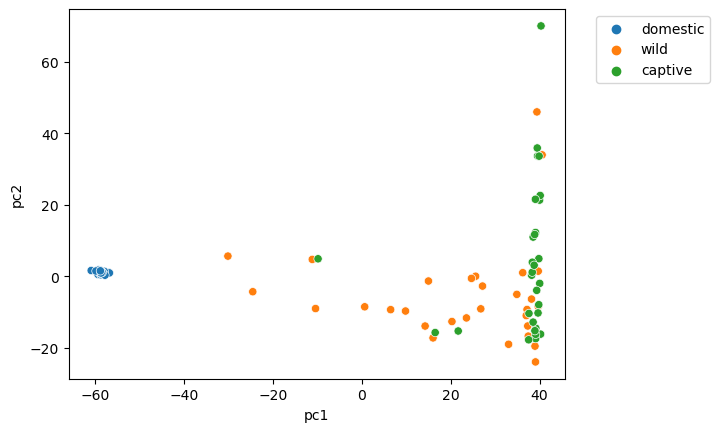

In [7]:
from sim.sum_stats import pca
data.allelify()  # convert from numpy to scikit allel equivilents
pca_data = pca(data.genotypes["all_pops"].to_n_alt(), data.subpops)  # to_n_alt converts to 012 format
sns.scatterplot(x=pca_data["pc1"], y=pca_data["pc2"], hue=pca_data["population"])
plt.legend(bbox_to_anchor=(1.05, 1))

## Real data

The way I got the real data into the same format as the results from the simulations (i.e. an instance of the `GenotypeData` class) is shown below.

In [ ]:
import allel
from sim.model import GenotypeData
callset = allel.read_vcf("../data/e3_phased.vcf")
pop = pd.read_csv("../data/e3_sample_info.csv", usecols=["SOURCE"])["SOURCE"].str.lower().to_numpy().ravel()

subpops = {}
for pop_name in np.unique(pop):
    subpops[pop_name] = np.where(pop == pop_name)[0]

subpops["all_pops"] = np.arange(len(pop))

y_obs = GenotypeData(callset=callset, subpops=subpops, seq_length=44648284)

with open("../data/e3_phased.pkl", "wb") as f:
    pickle.dump(y_obs, f)


Note this will automatically converts the data to biallelic matrices. It also saves the object created using pickle.

In [ ]:
import allel
from sim.model import GenotypeData
import pandas as pd
import numpy as np
import pickle

callset = allel.read_vcf("../data/e2_phased.vcf")  # Genotype data
pop = np.genfromtxt("../data/e2_sample_info.txt", dtype="str", usecols=1)  # populations
pop = np.where(pop == "dom", "domestic", pop)
pop = np.where(pop == "cap", "captive", pop)

subpops = {}
for pop_name in np.unique(pop):
    subpops[pop_name] = np.where(pop == pop_name)[0]

subpops["all_pops"] = np.arange(len(pop))

y_obs = GenotypeData(callset=callset, subpops=subpops, seq_length=64340295)

with open("../data/e2_phased.pkl", "wb") as f:
    pickle.dump(y_obs, f)

### Calculate observed statistics

In [ ]:
with open("../data/e2_phased.pkl", "rb") as f:
     test = pickle.load(f)

from sim.sum_stats import simple_sum
observed_sum_stats = simple_sum(y_obs)
observed_sum_stats = {k: [v] for k, v in observed_sum_stats.items()}
observed_sum_stats = pd.DataFrame.from_dict(observed_sum_stats)
observed_sum_stats.to_csv("../output/observed_summary_stats_e2.csv", index = False)